# Import Packages

In [1]:
## download ckpt.t7 from
# https://drive.google.com/drive/folders/1xhG0kRH1EX5B9_Iz8gQJb7UNnn_riXi6
# to deep_sort/deep/checkpoint

In [2]:
# !wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny-3l.cfg
# !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
# !git clone https://github.com/JonathonLuiten/TrackEval

In [1]:
%load_ext autoreload
%autoreload

In [31]:
import pandas as pd 
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import cv2, glob, os, torch, math, torchvision, datetime
from pl_bolts.models.detection import YOLO, YOLOConfiguration
from tqdm.notebook import tqdm 
import utm

# my files
from pedestrian_tracker.deep_sort import DeepSort
from pedestrian_tracker.naive_sort import Sort
import draw_utils, transform_utils
from trajectory_extractor import TrajectoryExtractor
from flow_predictor.cmgraph import parse_gcs, GCSDatasetLoaderStatic, BatchLitDataModule, BatchLitWrapper

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Defined User Args

In [77]:
# other videos
class TrajectoryExtractorArgs: 
    detector_name = 'YOLO'
    tracker_name = 'DeepSORT'
    max_iou_dist=0.9
    max_age=3
    max_cos_dist=0.5
    confidence_threshold=0.01 #YOLO: 0.01 GCS, 0.7 Y2E2; FRCNN: 0.01 GCS, 0.68 Y2E2
    
    unique_suffix = str(datetime.datetime.now().date()) + '_' + str(datetime.datetime.now().time()).replace(':', '.')
    input_video_path = "videos/Stadium/00084.wmv"
#     input_video_path = "videos/Y2E2/Y2E2_West.MOV"
#     input_video_path = "videos/GCS/grandcentral.avi" # cannot use because no gt. fml.
#     input_video_path = "videos/GCS/slideshow.avi" # Use this for paper YOLO. 
    
    output_txt_folder = 'TrackEval/data/trackers/mot_challenge/GCS-val/{}_{}_{}'.format(detector_name, tracker_name, unique_suffix)
    if not os.path.exists(output_txt_folder):
        os.makedirs(output_txt_folder)
        os.makedirs(output_txt_folder+'/data')
    output_txt_path = output_txt_folder+'/data/seq-01.txt'
    args_save_txt_path = output_txt_folder+'/args.txt'
    output_video_path = os.path.split(input_video_path)[0]+"/final_out/{}_{}_{}.avi".format(detector_name, tracker_name, unique_suffix)
    
#     yolo_config_path = "yolo/yolov4-tiny-3l.cfg"
#     yolo_pre_weights_path = "yolo/yolov4-tiny.weights"
    yolo_config_path = "pedestrian_detector/yolo/yolov7-tiny.cfg"
    yolo_pre_weights_path = "pedestrian_detector/yolo/yolov7-tiny.weights"

    deepsort_parameters_path = "pedestrian_tracker/deep/checkpoint/ckpt.t7"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
args = TrajectoryExtractorArgs

In [78]:
args.output_txt_path, args.output_video_path

('TrackEval/data/trackers/mot_challenge/GCS-val/YOLO_DeepSORT_2022-12-15_13.04.13.694272/data/seq-01.txt',
 'videos/Stadium/final_out/YOLO_DeepSORT_2022-12-15_13.04.13.694272.avi')

# Step 1: DL model to track human locations in frames

In [79]:
# set up our extractor
extractor = TrajectoryExtractor(args)

##################################################
if args.detector_name == 'YOLO':
    # set up yolo
    yolo_config = YOLOConfiguration(args.yolo_config_path)
    yolo_config.width = extractor.imw
    yolo_config.height = extractor.imh
    model = YOLO(network=yolo_config.get_network()).to(device)
    with open(args.yolo_pre_weights_path) as pre_weights: 
        model.load_darknet_weights(pre_weights)

    extractor.load_detector(model)

elif args.detector_name == 'FasterRCNN':
    # set up faster rcnn
    
    # implemented to add the "infer" function to infer on single image 
    anchor_generator = torchvision.models.detection.anchor_utils.AnchorGenerator(sizes=((8, 16, 32, 64, 128),),
                                                                                 aspect_ratios=((0.5, 1.0),))
    class modified_FasterRCNN(torch.nn.Module): 
        def __init__(self, **kwargs):
            super().__init__()
            self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(**kwargs)
        def infer(self, rgb_tensor): 
            # single image
            pred_dict = self.model([rgb_tensor])[0]
            boxes = pred_dict['boxes'] # (N,4)
            labels = pred_dict['labels'] # (N)
            labels = [l - 1 for l in labels] # subtract 1 from class IDs because coco classes have background=0. person=1
            confidences = pred_dict['scores'] # (N)  
            num_boxes = boxes.shape[0]
            
            return boxes, confidences, labels
    
#     model = modified_FasterRCNN(weights='DEFAULT', 
#                                 weights_backbone = 'DEFAULT',
#                                 box_score_thresh=args.confidence_threshold, 
#                                 box_nms_thresh=0.1,
#                                 box_detections_per_img=300,
#                                ).to(device)
    model = modified_FasterRCNN(weights='DEFAULT').to(device)
    extractor.load_detector(model)

##################################################
if args.tracker_name == 'DeepSORT':
    # set up deepsort
    extractor.load_tracker(
        DeepSort(args.deepsort_parameters_path, 
                 min_confidence = args.confidence_threshold,
                 max_dist = args.max_cos_dist, 
                 max_iou_distance = args.max_iou_dist, 
                 max_age = args.max_age,
#                  nms_max_overlap=1000
                )
    )

elif args.tracker_name == 'SORT': 
    # set up sort
    extractor.load_tracker(
        Sort(max_age=args.max_age, 
             min_hits=3,
             iou_threshold = 1- args.max_iou_dist)
    )


detector_out_df, tracker_out_df, txt_df = extractor.detect_all(
    max_frames=1000,
    skip_every_n_frames = 1
)

extractor.release_all()

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


Loading video from videos/Stadium/00084.wmv...
29
Loaded video has 18079 frames at FPS 29, size 720x480
transformed to size 736x480


100%|███████████████████████████████████████| 1000/1000 [01:37<00:00, 10.23it/s]


# Step 2: Obtain 2D Plane Projection

In [80]:
# precomputed homography matrices
############# STADIUM #############
pts_img = [[450.0,203.0],[282.0,297.0],[470.0,403.0],[630.0,270.0]] # top left, bot left, bot right, top right 
pts_world = [[250,250], [250,500], [500,500],[500,250]]

HOMOG, status = cv2.findHomography(np.array(pts_img), np.array(pts_world)+700)

############# GCS #############
# HOMOG = np.array([[4.97412897e-02, -4.24730883e-02, 7.25543911e+01],
#          [1.45017874e-01, -3.35678711e-03, 7.97920970e+00],
#          [1.36068797e-03, -4.98339188e-05, 1.00000000e+00]])

############# Y2E2 West #############
# #note: points must be consistent in order and winding (e.g. clockwise) 
# pts_img = [[1090, 1625], [2270, 1785], [2010, 2250], [470, 2150]] # palm tree locations 
# long_lat_world = [(37.428570, -122.175184), (37.428489, -122.175211), 
#                   (37.428506, -122.175288), (37.428589, -122.175260)]
# pts_world = []
# for lat,lon in long_lat_world: 
#     utm_east, utm_north, utm_zone, utm_letter = utm.from_latlon(lat,lon) # meters
#     pts_world.append([utm_east*100, utm_north*100]) # centimeters
# # shift pts_world so that values aren't too big
# world_np = np.array(pts_world)
# world_np = world_np - world_np.min(axis=0)
# pts_world = world_np.tolist()

    
# HOMOG, status = cv2.findHomography(np.array(pts_img), np.array(pts_world))

In [81]:
HOMOG

array([[ 2.38612669e+00,  8.92843370e+00, -8.05853261e+02],
       [-1.35026931e+00,  9.30207330e+00,  7.99676100e+02],
       [ 2.37786074e-04,  5.33431289e-03,  1.00000000e+00]])

# Step 3: Obtain the transformed human trajectories in world coordinates

In [82]:
pedestrian_df = tracker_out_df.copy()
pedestrian_df.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,person_id,crowd_count,frame_number
0,173,124,255,322,1,17,3
1,301,41,365,172,2,17,3
2,552,106,627,272,3,17,3
3,99,204,184,431,4,17,3
4,90,38,145,154,5,17,3


In [83]:
def image_to_world(p, Homog):
    '''
    p: a np array of [x1, y1; x2, y2; ... ] 
    '''
    # from Opentraj repo
    pp = np.stack((p[:, 0], p[:, 1], np.ones(len(p))), axis=1) # append a rightmost column of 1s
    PP = np.matmul(Homog, pp.T).T # [world x, world y, 1] (3 x 3)
    P_normal = PP / np.repeat(PP[:, 2].reshape((-1, 1)), 3, axis=1)  # normalize since the third column is not exactly 1??
    return P_normal[:, :2]*0.8 # not sure why *0.8 but that's in the code. 

# parse original annotations to see which agents have been split due to noncontinuous timestamps
# note some trajs too short removed

In [84]:
pedestrian_df['img_x'] = (pedestrian_df['bbox_x1'] + pedestrian_df['bbox_x2'])/2
pedestrian_df['img_y'] = pedestrian_df['bbox_y2']
pedestrian_df[['pos_x', 'pos_y']] = image_to_world(pedestrian_df[['img_x','img_y']].to_numpy(), 
                                                                 HOMOG)
pedestrian_df.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,person_id,crowd_count,frame_number,img_x,img_y,pos_x,pos_y
0,173,124,255,322,1,17,3,214.0,322,745.443645,1013.094970
1,301,41,365,172,2,17,3,333.0,172,610.779504,781.292366
2,552,106,627,272,3,17,3,589.5,272,935.291740,782.323633
3,99,204,184,431,4,17,3,141.5,431,811.330752,1108.472356
4,90,38,145,154,5,17,3,117.5,154,367.463769,896.944644


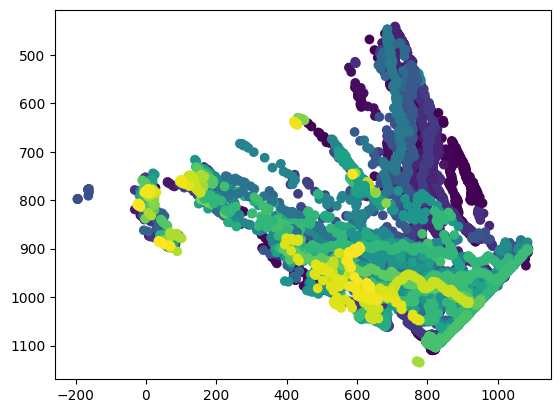

In [85]:
plt.gca().invert_yaxis()
plt.scatter(pedestrian_df['pos_x'],pedestrian_df['pos_y'],c=pedestrian_df['person_id'])

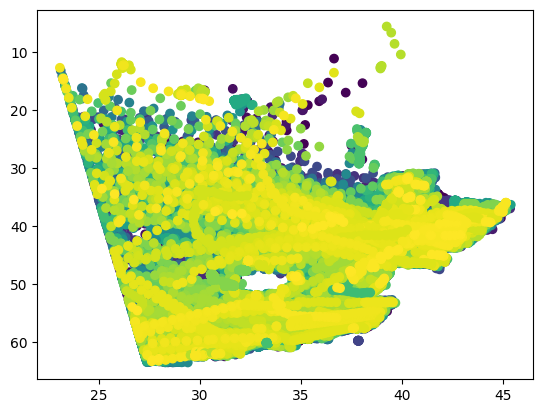

In [51]:
plt.gca().invert_yaxis()
plt.scatter(pedestrian_df['pos_x'],pedestrian_df['pos_y'],c=pedestrian_df['person_id'])
# TODO: figure out why this looks different from ground truth in GCS
# I think it's because the annotation's origin definition is different from the bbox's?

In [37]:
pedestrian_df2 = pd.concat(trajs) # original annotations
pedestrian_df2.head()

,index,frame_id,agent_id,pos_x,pos_y,timestamp,vel_x,vel_y
0,0,0,1,39.531444,16.780638,0.0,-0.834921,1.868034
1,1,20,1,38.863508,18.275066,0.8,-0.834921,1.868034
2,2,40,1,38.562653,19.421289,1.6,-0.376068,1.432779
3,3,60,1,38.185597,20.377113,2.4,-0.471320,1.194780
4,4,80,1,37.888498,21.381171,3.2,-0.371374,1.255072


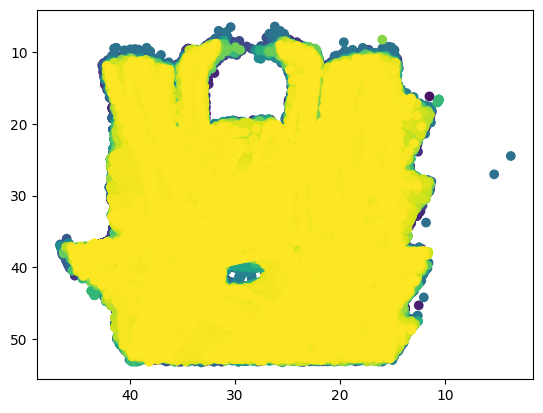

In [55]:
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.scatter(pedestrian_df2['pos_x'],pedestrian_df2['pos_y'],c=pedestrian_df2['agent_id'])

# Step 4: Identify crowdedness severity

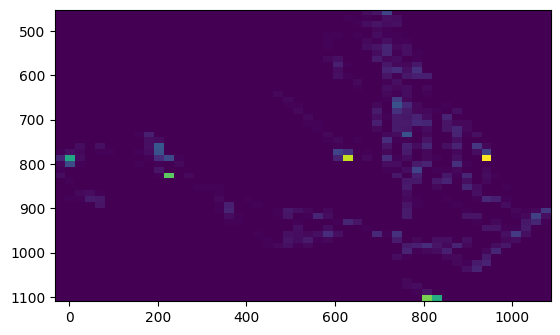

In [92]:
# density heatmap 
# TODO: flip this x axis.
x,y = (pedestrian_df.query('frame_number<=150')[['pos_x', 'pos_y']].values[:,0],
       pedestrian_df.query('frame_number<=150')[['pos_x', 'pos_y']].values[:,1])
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]] #(left, right, bottom, top)

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='upper')
plt.show()

# Step 5: CMGraph

In [32]:
%%time
trajs= parse_gcs("videos/GCS/Annotation")

0it [00:00, ?it/s]

CPU times: user 35 s, sys: 497 ms, total: 35.5 s
Wall time: 34.9 s


/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [6]:
# 7 zones. each zone (x1, y1, x2, y2)
ZONE_LIST =[
    (0, 0, 28, 14),
    (28, 0, 55, 14),
    (0, 14, 28, 24),
    (28, 14, 55, 24),
    (0, 24, 28, 35),
    (28, 24, 55, 35),
    (0, 35, 28, 45),
    (28, 35, 55, 45),
    (0, 45, 55, 55)
]
loader = GCSDatasetLoaderStatic(
    trajs=trajs,
    ZONE_LIST = ZONE_LIST)

In [7]:
dataset = loader.get_dataset(num_timesteps_in=20, num_timesteps_out=20)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(list(dataset)))
print(next(iter(dataset))) # Show first sample

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7f1914c919f0>
Number of samples / sequences:  5173
Data(x=[9, 2, 20], edge_index=[2, 36], edge_attr=[36], y=[9, 20])


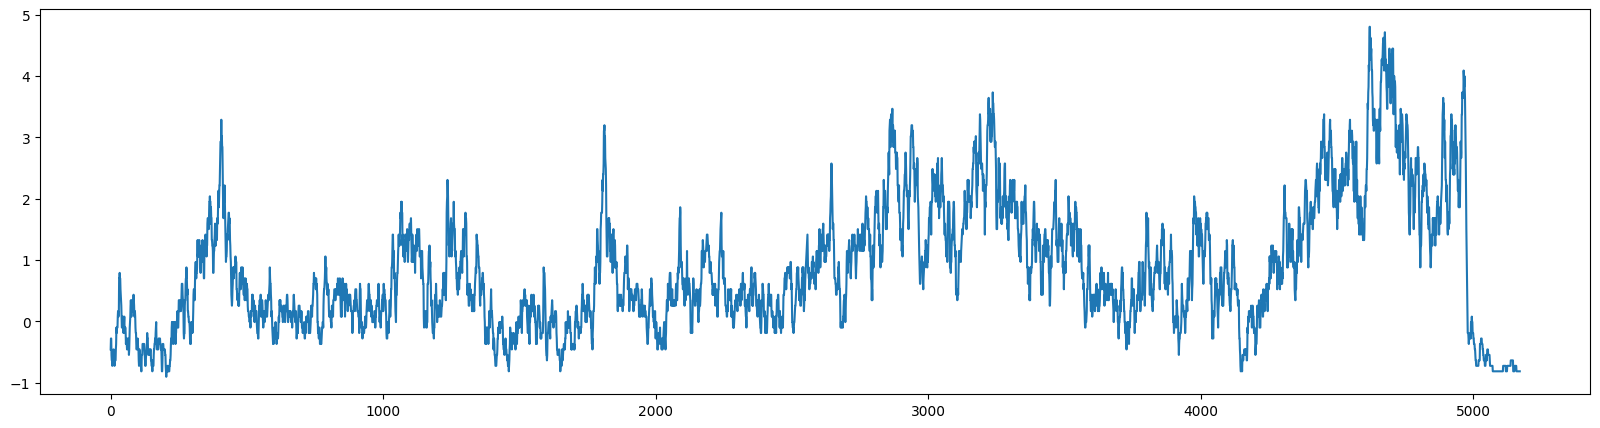

In [8]:
# Visualize traffic over time
plt.figure(figsize=(20,5))
zone_number = 8
time = -1
zone_labels = [bucket.y[zone_number][0].item() for bucket in list(dataset)[:time]]
plt.plot(zone_labels)

In [9]:
batch_size = 32

input_np = np.array(dataset.features) 
target_np = np.array(dataset.targets) 
input_tensor = torch.from_numpy(input_np).type(torch.FloatTensor).to(args.device)  # (B, N, F, T)
target_tensor = torch.from_numpy(target_np).type(torch.FloatTensor).to(args.device)  # (B, N, T)
dataset_new = torch.utils.data.TensorDataset(input_tensor, target_tensor)

proportions = [0.7,0.3]
lengths = [int(p * len(dataset_new)) for p in proportions]
lengths[-1] = len(dataset_new) - sum(lengths[:-1])
train_dataset_new, test_dataset_new = torch.utils.data.random_split(dataset_new, lengths, generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=False)

print("Number of train buckets: ", len(list(train_dataset_new)))
print("Number of test buckets: ", len(list(test_dataset_new)))

Number of train buckets:  3621
Number of test buckets:  1552


In [20]:
from torch_geometric_temporal.nn.recurrent import *
from torch_geometric_temporal.nn.attention import *
from torch_geometric.nn import GCNConv
class GCNGRU(torch.nn.Module):
    r"""An implementation THAT SUPPORTS BATCHES of the Attention Temporal Graph Convolutional Cell.
    For details see this paper: `"A3T-GCN: Attention Temporal Graph Convolutional
    Network for Traffic Forecasting." <https://arxiv.org/abs/2006.11583>`_
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        periods (int): Number of time periods.
        improved (bool): Stronger self loops (default :obj:`False`).
        cached (bool): Caching the message weights (default :obj:`False`).
        add_self_loops (bool): Adding self-loops for smoothing (default :obj:`True`).
    """

    def __init__(
        self,
        in_channels: int,  
        periods: int, 
        batch_size:int, 
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True):
        super(GCNGRU, self).__init__()

        self.in_channels = in_channels  # 2
        self.periods = periods # 12
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops
        self.batch_size = batch_size
        self._setup_layers()

    def _setup_layers(self):
        self.gcn1 = GCNConv(
            in_channels=self.in_channels,
            out_channels=128,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )
        self.gcn2 = GCNConv(
            in_channels=128,
            out_channels=128,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )
        self.gcn3 = GCNConv(
            in_channels=128,
            out_channels=128,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )
        self.gru = torch.nn.GRU(128,64,2,batch_first=True)
        self.fc = torch.nn.Linear(64, 1)

    def forward( 
        self, 
        X: torch.FloatTensor,
        edge_index: torch.LongTensor, 
        edge_weight: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.
        Arg types:
            * **X** (PyTorch Float Tensor): Node features for T time periods.
            * **edge_index** (PyTorch Long Tensor): Graph edge indices.
            * **edge_weight** (PyTorch Long Tensor, optional)*: Edge weight vector.
            * **H** (PyTorch Float Tensor, optional): Hidden state matrix for all nodes.
        Return types:
            * **H** (PyTorch Float Tensor): Hidden state matrix for all nodes.
        """
        gru_in = torch.zeros(X.shape[0],X.shape[1],self.periods,128).to(X.device) # (B,N,T,F_out_GCN)
        for period in range(self.periods):
            gcn_out = self.gcn1(X[:, :, :, period], edge_index, edge_weight) # (B, N, Fout)
            gcn_out = self.gcn2(gcn_out, edge_index, edge_weight) # (B, N, Fout)
            gcn_out = self.gcn3(gcn_out, edge_index, edge_weight) # (B, N, Fout)
            gru_in[:,:,period,:] = gcn_out
        gru_in = gru_in.flatten(start_dim=0, end_dim=1) # (B*N, T, F_out_GCN)
        gru_out, _ = self.gru(gru_in) # (B*N,T,H)
        out = self.fc(gru_out) # (B*N, T, 1)
        out = out.view(X.shape[0], X.shape[1], self.periods, -1) # (B,N,T,1)
        return out.squeeze(dim=3) # (B,N,T)
    
class A3TGCN_2(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(A3TGCN_2, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=64, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.fc = torch.nn.Linear(64, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = self.fc(h)
        return h

class TGCN_2(torch.nn.Module): 
    r"""An implementation THAT SUPPORTS BATCHES of the Attention Temporal Graph Convolutional Cell.
    For details see this paper: `"A3T-GCN: Attention Temporal Graph Convolutional
    Network for Traffic Forecasting." <https://arxiv.org/abs/2006.11583>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        periods (int): Number of time periods.
        improved (bool): Stronger self loops (default :obj:`False`).
        cached (bool): Caching the message weights (default :obj:`False`).
        add_self_loops (bool): Adding self-loops for smoothing (default :obj:`True`).
    """

    def __init__(self, node_features, periods, batch_size,
            improved: bool = False,
            cached: bool = False,
            add_self_loops: bool = True):
        super(TGCN_2, self).__init__()
        self.tgnn = TGCN2(
            in_channels=node_features,
            out_channels=64,  
            batch_size=batch_size,
            improved=improved,
            cached=cached, 
            add_self_loops=add_self_loops)
        # Equals single-shot prediction
        self.fc = torch.nn.Linear(64, periods)
        self.periods = periods

    def forward( 
        self, 
        X: torch.FloatTensor,
        edge_index: torch.LongTensor, 
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None
    ) -> torch.FloatTensor:
        for period in range(self.periods):

            out = self.tgnn( X[:, :, :, period], edge_index, edge_weight, H) #([B, N, Fout]
        return self.fc(out)

In [21]:
# print('Net\'s state_dict:')
# total_param = 0
# for param_tensor in model.state_dict():
#     print(param_tensor, '\t', model.state_dict()[param_tensor].size())
#     total_param += np.prod(model.state_dict()[param_tensor].size())
# print('Net\'s total params:', total_param)
# #--------------------------------------------------
# print('Optimizer\'s state_dict:')
# for var_name in optimizer.state_dict():
#     print(var_name, '\t', optimizer.state_dict()[var_name])

In [27]:
%%time
# Create model and optimizers
model = A3TGCN_2(node_features=2, periods=20, batch_size=batch_size).to(args.device)
# model = TGCN_2(node_features=2, periods=20, batch_size=batch_size).to(args.device)
# model = GCNGRU(in_channels=2, periods=20, batch_size=batch_size).to(args.device)
loss_fn = torch.nn.MSELoss()
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for snapshot in dataset:
    static_edge_index = snapshot.edge_index.to(args.device)
    break;
    
for epoch in range(40):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print("Epoch {} Step {} train MSE: {:.4f}".format(epoch, step, sum(loss_list)/len(loss_list)))
        step= step+ 1

Epoch 0 Step 0 train MSE: 1.0174
Epoch 0 Step 100 train MSE: 0.5495
Epoch 1 Step 0 train MSE: 0.3903
Epoch 1 Step 100 train MSE: 0.3556
Epoch 2 Step 0 train MSE: 0.3999
Epoch 2 Step 100 train MSE: 0.3490
Epoch 3 Step 0 train MSE: 0.3384
Epoch 3 Step 100 train MSE: 0.3458
Epoch 4 Step 0 train MSE: 0.2866
Epoch 4 Step 100 train MSE: 0.3431
Epoch 5 Step 0 train MSE: 0.3555
Epoch 5 Step 100 train MSE: 0.3373
Epoch 6 Step 0 train MSE: 0.3436
Epoch 6 Step 100 train MSE: 0.3364
Epoch 7 Step 0 train MSE: 0.3197
Epoch 7 Step 100 train MSE: 0.3312
Epoch 8 Step 0 train MSE: 0.2742
Epoch 8 Step 100 train MSE: 0.3273
Epoch 9 Step 0 train MSE: 0.2676
Epoch 9 Step 100 train MSE: 0.3239
Epoch 10 Step 0 train MSE: 0.2855
Epoch 10 Step 100 train MSE: 0.3260
Epoch 11 Step 0 train MSE: 0.3387
Epoch 11 Step 100 train MSE: 0.3262
Epoch 12 Step 0 train MSE: 0.3770
Epoch 12 Step 100 train MSE: 0.3263
Epoch 13 Step 0 train MSE: 0.3147
Epoch 13 Step 100 train MSE: 0.3222
Epoch 14 Step 0 train MSE: 0.3345


KeyboardInterrupt: 

In [28]:
filename = 'flow_predictor/checkpoints/'+model.__class__.__name__+'.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': sum(loss_list)/len(loss_list),
            }, filename)
filename

'flow_predictor/checkpoints/A3TGCN_2.pt'

In [40]:
# load checkpoint
model = GCNGRU(in_channels=2, periods=20, batch_size=batch_size).to(args.device)
checkpoint = torch.load('flow_predictor/checkpoints/GCNGRU.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(model)

model.train()
sum(p.numel() for p in model.parameters() if p.requires_grad)

GCNGRU(
  (gcn1): GCNConv(2, 128)
  (gcn2): GCNConv(128, 128)
  (gcn3): GCNConv(128, 128)
  (gru): GRU(128, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


95681

In [32]:
%%time
import torch.nn.functional as F
torch.no_grad()
model.eval()
# Store for analysis
total_loss = []
total_mae = []
for snapshot in dataset:
    static_edge_index = snapshot.edge_index.to(args.device)
    break;
    
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    mae = F.l1_loss(y_hat, labels)
    total_loss.append(loss.item())
    total_mae.append(mae.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))
print("Test MAE: {:.4f}".format(sum(total_mae)/len(total_mae)))

Test MSE: 0.3201
Test MAE: 0.4032
CPU times: user 1.76 s, sys: 12 ms, total: 1.77 s
Wall time: 1.77 s


In [30]:
y_hat.shape

torch.Size([16, 9, 20])

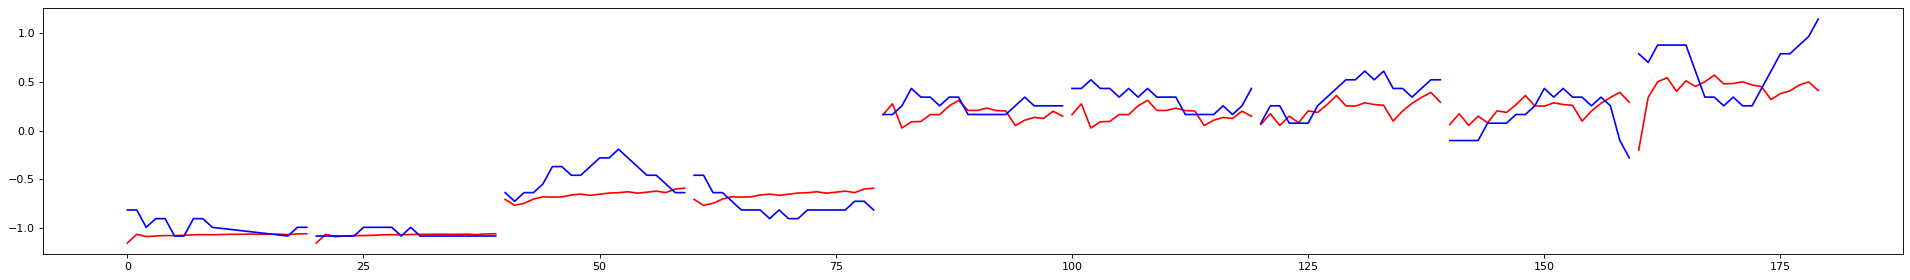

In [203]:
'''GCNGRU: 'flow_predictor/checkpoints/GCNGRU.pt'
Test MSE: 0.2575
Test MAE: 0.3541
CPU times: user 7.98 s, sys: 8.02 ms, total: 7.99 s
Wall time: 1.64 s
'''
# visualize each zone
from matplotlib.pyplot import figure
sample_output = y_hat[5]
sample_labels = labels[5] # (9, 20)
figure(figsize=(30,4), dpi=80)
for i in range(len(ZONE_LIST)):
    new_i = i * 20
    plt.plot(range(0+new_i,20+new_i),sample_output[i].detach().cpu().numpy(), color = 'red')
    plt.plot(range(0+new_i,20+new_i),sample_labels[i].cpu().numpy(), color='blue')
plt.show()

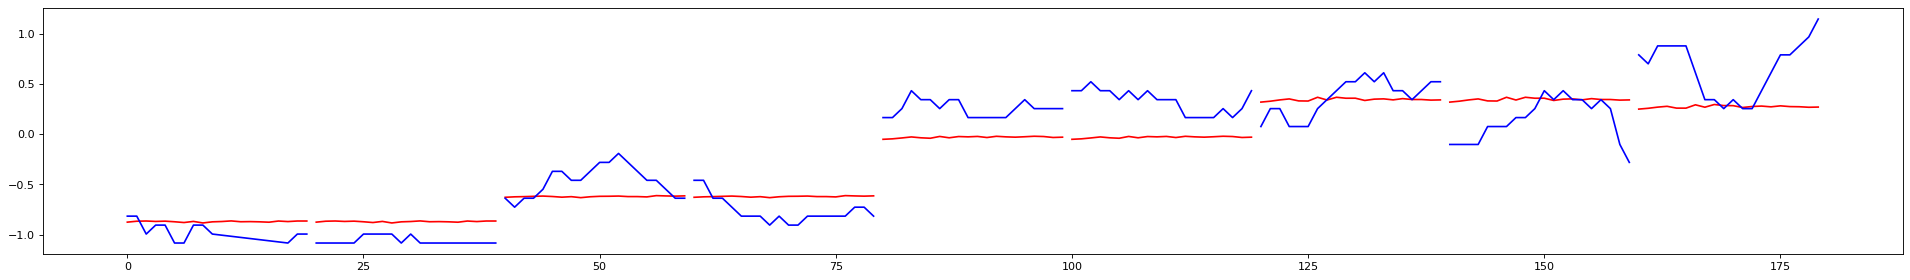

In [26]:
'''TGCN2: 'flow_predictor/checkpoints/TGCN_2.pt'
Test MSE: 0.3285
Test MAE: 0.4170
CPU times: user 1.75 s, sys: 15.9 ms, total: 1.77 s
Wall time: 1.77 s
'''
# visualize each zone
from matplotlib.pyplot import figure
sample_output = y_hat[5]
sample_labels = labels[5] # (9, 20)
figure(figsize=(30,4), dpi=80)
for i in range(len(ZONE_LIST)):
    new_i = i * 20
    plt.plot(range(0+new_i,20+new_i),sample_output[i].detach().cpu().numpy(), color = 'red')
    plt.plot(range(0+new_i,20+new_i),sample_labels[i].cpu().numpy(), color='blue')
plt.show()

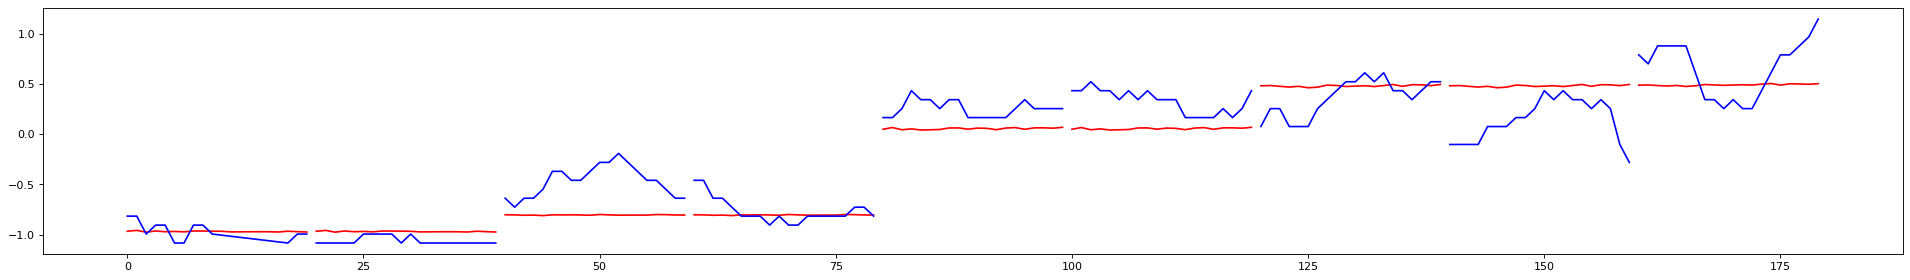

In [31]:
'''A3TGCN2: 'flow_predictor/checkpoints/A3TGCN_2.pt'
Test MSE: 0.3201
Test MAE: 0.4032
CPU times: user 1.76 s, sys: 12 ms, total: 1.77 s
Wall time: 1.77 s
'''
# visualize each zone
from matplotlib.pyplot import figure
sample_output = y_hat[5]
sample_labels = labels[5] # (9, 20)
figure(figsize=(30,4), dpi=80)
for i in range(len(ZONE_LIST)):
    new_i = i * 20
    plt.plot(range(0+new_i,20+new_i),sample_output[i].detach().cpu().numpy(), color = 'red')
    plt.plot(range(0+new_i,20+new_i),sample_labels[i].cpu().numpy(), color='blue')
plt.show()

In [60]:
zone = 8
data_idx = 0
history = encoder_inputs[data_idx, zone,0,:].detach().cpu().numpy()
preds = y_hat[data_idx,zone,:].detach().cpu().numpy()
labs = labels[data_idx,zone,:].detach().cpu().numpy()
print("Data points:,", preds.shape)

Data points:, (20,)


In [69]:
tensor = torch.randn(2, 3, 4)

# Use the flatten method to combine the first two dimensions
# This gives a tensor with dimensions (6, 4)
flattened_tensor = tensor.flatten(start_dim=0, end_dim=1)
print(flattened_tensor.shape)

torch.Size([6, 4])


In [70]:
tensor, flattened_tensor

(tensor([[[-1.0039,  0.3330, -0.6818,  2.0718],
          [-0.6782, -0.1151,  1.0658,  1.1113],
          [-0.9638, -0.7321, -0.1658, -0.0574]],
 
         [[-0.8340, -0.7911,  0.8372, -0.1122],
          [ 2.5375,  1.1452, -0.8999,  0.7675],
          [ 0.4185, -0.5415, -0.2288, -1.0190]]]),
 tensor([[-1.0039,  0.3330, -0.6818,  2.0718],
         [-0.6782, -0.1151,  1.0658,  1.1113],
         [-0.9638, -0.7321, -0.1658, -0.0574],
         [-0.8340, -0.7911,  0.8372, -0.1122],
         [ 2.5375,  1.1452, -0.8999,  0.7675],
         [ 0.4185, -0.5415, -0.2288, -1.0190]]))

In [71]:
reshaped_tensor = flattened_tensor.view(2, 3, 4)
reshaped_tensor==tensor

tensor([[[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]],

        [[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]]])

In [61]:
# visualize prediction over time 
plt.figure(figsize=(20,5))
sns.lineplot(x=range(20), y=history, label="history")
sns.lineplot(x=range(19,39), y=preds, label="pred")
sns.lineplot(x=range(19,39), y=labs, label="true")

NameError: name 'sns' is not defined

<Figure size 2000x500 with 0 Axes>

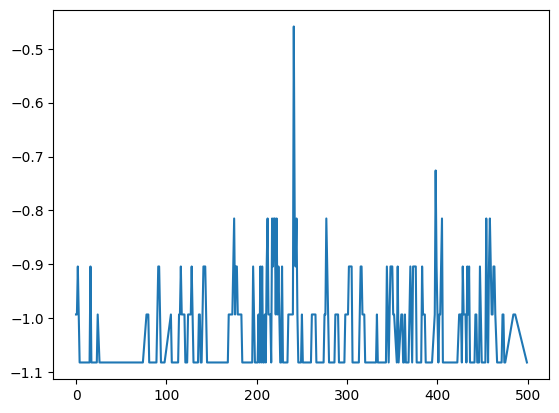

In [121]:
# Visualize traffic over time
zone = 1
timestep = 500
_labels = [batch.y[zone][0].item() for batch in list(dataset)[:timestep]]
plt.plot(_labels)